In [13]:
import regionmask
import pyproj
import xskillscore as xs
import CMIP6_xgrid_utils
from CMIP6_IO import CMIP6_IO
from CMIP6_ridgeplot import CMIP6_ridgeplot
import logging
import global_land_mask
from matplotlib import cm
import geopandas as gpd
from shapely.geometry import box, mapping
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import seaborn as sns
import os
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.dates as mdates
import cftime
warnings.filterwarnings("ignore")

logging.getLogger("xclim").setLevel("ERROR")
logging.getLogger("root").setLevel("ERROR")
sns.set_theme(font_scale=1.5, style="whitegrid")

io = CMIP6_IO()

In [14]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)


def get_LME_records_180():
    lme_file = "gs://actea-shared/Shapefiles/LME66_180/LME66_180.shp"
    return gpd.read_file(lme_file)


def create_colors(N):
    color = iter(cm.tab20b(np.linspace(0, 1, N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds, LME, var_name, latname="lat", lonname="lon"):
    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[shdf["LME_NAME"] == LME]
    clipped = None

    ds = ds.rio.write_crs("epsg:4326", inplace=True)
    ds = ds.rio.set_spatial_dims(x_dim=lonname, y_dim=latname, inplace=True)

    clipped = ds.rio.clip(
        geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    # Mask out indices where values are always zero across latitude
    clipped = clipped.fillna(0.0)
    always_zero = ~(clipped[var_name].any(dim='time') != 0)
    masked_da = clipped.where(~always_zero)

    constant_masked = (masked_da[var_name].std(dim='time') == 0)
    masked_da = masked_da.where(~constant_masked)

    return masked_da

In [15]:
def convert_to_180(ds):
    ds = (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby("lon")
    return ds


def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes["time"].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds


def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")

    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)

    return xr.DataArray(mask_data, coords={"lat": lat, "lon": lon}, dims=["lat", "lon"])


def resample_to_frequency(ds: xr.Dataset, LME, var_name,  start_time, end_time, frequency, ocean_only=True):

    # Add land mask
    ds = xr.where(((ds < 1.0e-20) | (ds > 1e20)), np.nan, ds)
    # if var_name in ["sw_srf","uv_srf"]:

    minx = ds.lon.min().item()
    maxx = ds.lon.max().item()
    miny = ds.lat.min().item()
    maxy = ds.lat.max().item()

    # set up new lat/lon grid
    new_grid_x = np.arange(
        np.ceil(minx / 1.) * 1.,
        (np.floor(maxx / 1.) + 0.5) * 1.,
        1.
    )
    new_grid_y = np.arange(
        np.ceil(miny / 1) * 1.,
        (np.floor(maxy / 1.0) + 0.5) * 1.0,
        1.0
    )
    # interpolate using nearest neighbor (can use linear, etc. if desired)
    coarse = ds.interp(lon=new_grid_x, lat=new_grid_y, method="nearest")
    ds = convert_to_180(coarse)
    ds = convert_time(ds)
    ds = ds.sel(time=slice(start_time, end_time))

    ds_lme = get_data_within_LME(ds, LME, var_name)
    ds_lme["mask"] = create_land_ocean_mask(ds_lme)

    if ocean_only:
        ds_lme = ds_lme.where(ds_lme.mask == 1)

    return ds_lme.resample(time=frequency).mean()


def get_area_averaged_ds(
    fname_stats,
    LME,
    var_name,
    start_time,
    end_time,
    frequency,
    ocean_only=True,
) -> xr.Dataset:
    if isinstance(fname_stats, xr.Dataset):
        ds_stats = fname_stats
    else:
        ds_stats = io.open_dataset_on_gs(fname_stats)
  
    if isinstance(ds_stats, xr.Dataset):
        ds_stats = resample_to_frequency(
            ds_stats, LME, var_name, start_time, end_time, frequency, ocean_only=ocean_only
        )

    if isinstance(ds_stats, xr.Dataset):

        ds_stats = get_data_within_LME(ds_stats, LME, var_name)
        return ds_stats

In [16]:
def get_Greenland_station(ds_rtm_name, var_name):
    for station, lat, lon, units in zip(["PETERMANN_GLACIER",
                                         "NASA_U"],
                                        [80.75, 73.83329773],
                                        [306, 310.5100098],
                                        ["hours since 2003-05-25 01:00:00 +00:00",
                                         "hours since 1995-05-31 01:00:00 +00:00"]):

        era = netCDF4.Dataset(
            f"compare_S3S_rsds/Greenland_stations/gcnet_{station}.nc")

        time_gregorian = cftime.num2date(
            era.variables["TIME"], units, 'gregorian')
        times = []
        for t in time_gregorian:
            obj = datetime.datetime(
                year=t.year, month=t.month, day=t.month, hour=t.hour)
            times.append(obj)
        times = pd.to_datetime(times, dayfirst=False)

        ds_greenland = xr.open_dataset(
            f"compare_S3S_rsds/Greenland_stations/gcnet_{station}.nc")

        ds_greenland = ds_greenland.assign_coords({"TIME": times})
        ds_greenland = ds_greenland.rename({"TIME": "time"})
        ds_greenland = ds_greenland.groupby('time.year').mean('time')
        ds_rtm = io.open_dataset_on_gs(ds_rtm_name).sel(
            lat=lat, lon=lon, method="nearest").sel(time=slice("1995-01-01", "2008-12-31"))
        ds_rtm = ds_rtm.groupby('time.year').mean('time')

        ds_greenland["RSDS"].plot(label="Observations")
        ds_rtm[var_name].plot(label="RTM")

        plt.legend()
        plt.show()

Processing CanESM5_r3i1p2f1 ssp245 ghi Barents Sea
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r3i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r3i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.17930449545383453
pearson p=0.965


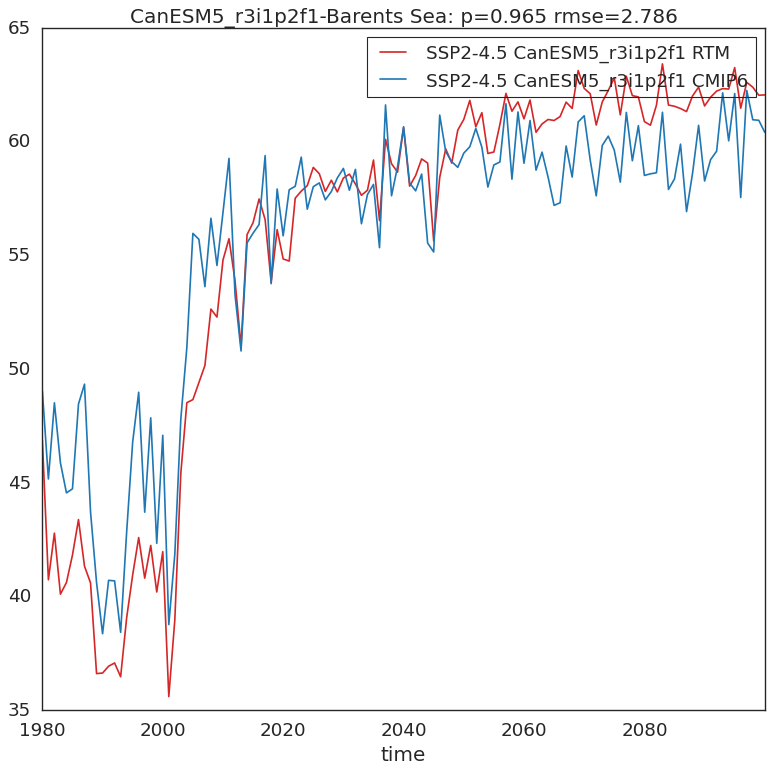

Correlation for Barents Sea CanESM5_r3i1p2f1  0.965 (<xarray.DataArray ()> Size: 8B
array(3.48840784e-71)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 2.786
Processing CanESM5_r3i1p2f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r3i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r3i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.3959093689918518
pearson p=0.972


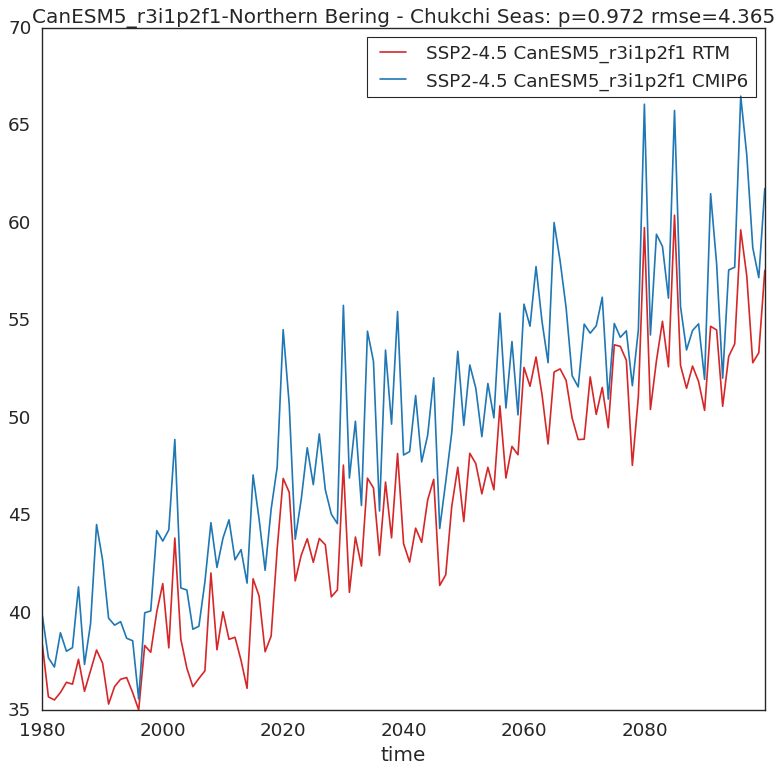

Correlation for Northern Bering - Chukchi Seas CanESM5_r3i1p2f1  0.972 (<xarray.DataArray ()> Size: 8B
array(1.97506208e-76)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 4.365
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}}
Processing CanESM5_r7i1p2f1 ssp245 ghi Barents Sea
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r7i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening fi

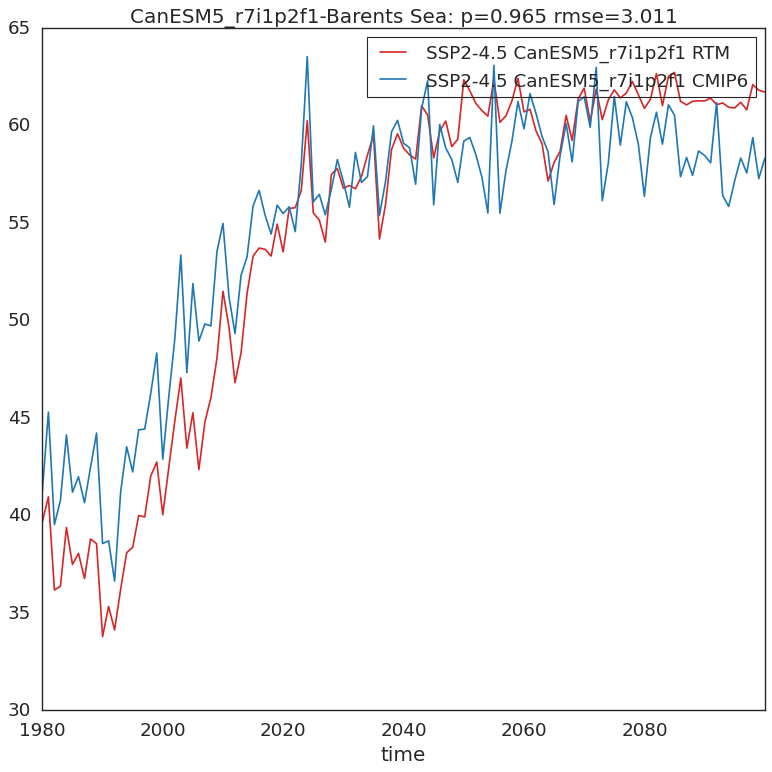

Correlation for Barents Sea CanESM5_r7i1p2f1  0.965 (<xarray.DataArray ()> Size: 8B
array(2.45506176e-71)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 3.011
Processing CanESM5_r7i1p2f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r7i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r7i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r7i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.3873419165611267
pearson p=0.973


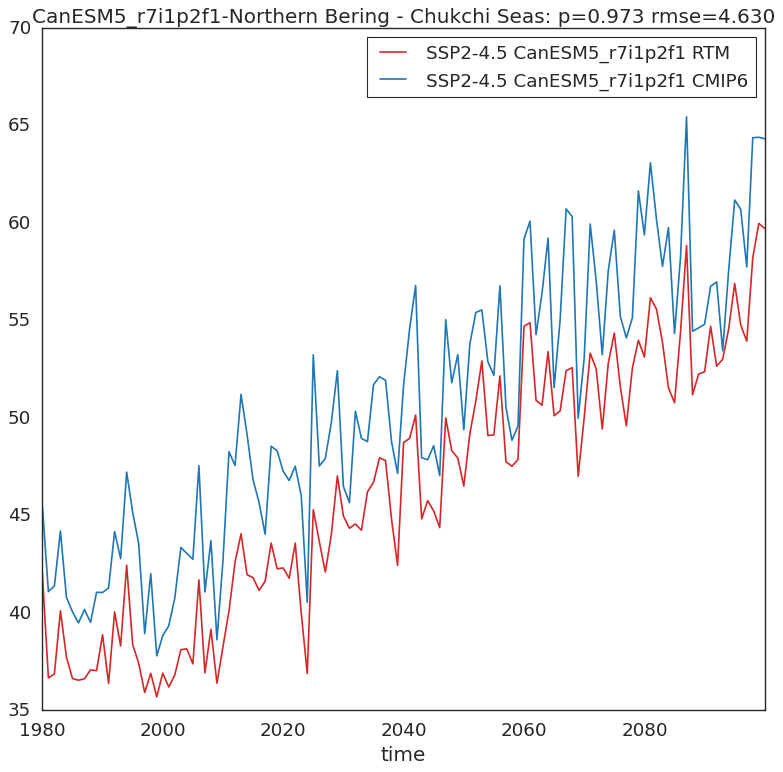

Correlation for Northern Bering - Chukchi Seas CanESM5_r7i1p2f1  0.973 (<xarray.DataArray ()> Size: 8B
array(1.29625549e-77)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 4.630
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}}
Processing CanESM5_r10i1p2f1 ssp245 ghi Barents Sea
[CMIP6_IO] Opening fil

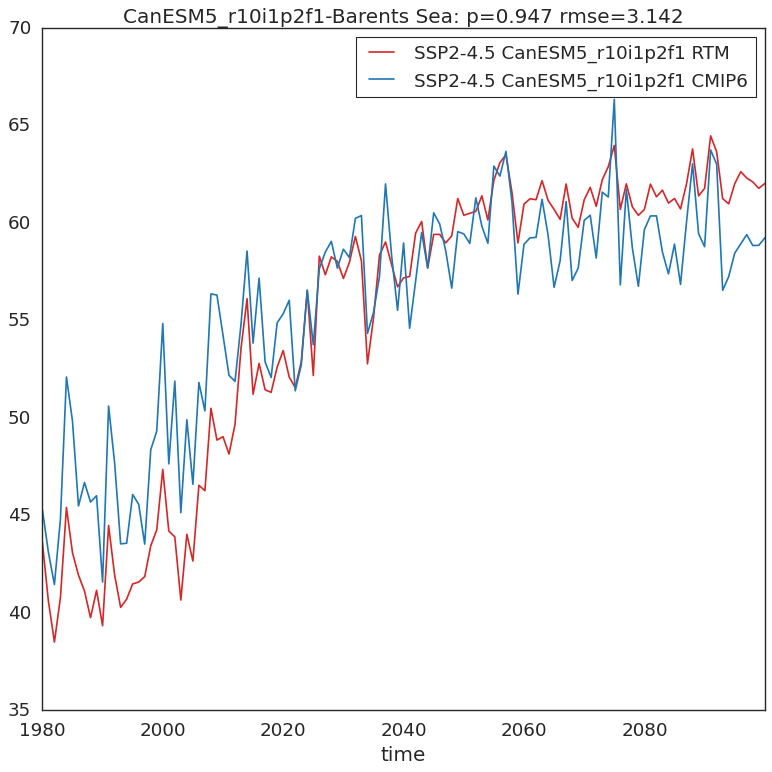

Correlation for Barents Sea CanESM5_r10i1p2f1  0.947 (<xarray.DataArray ()> Size: 8B
array(1.89450736e-60)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 3.142
Processing CanESM5_r10i1p2f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r10i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r10i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.38217610120773315
pearson p=0.981


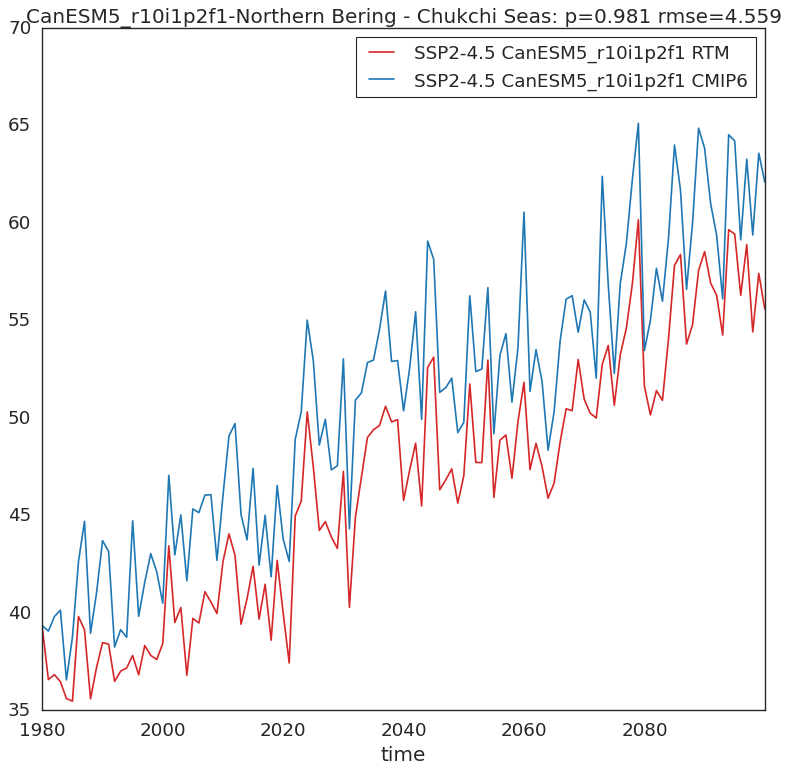

Correlation for Northern Bering - Chukchi Seas CanESM5_r10i1p2f1  0.981 (<xarray.DataArray ()> Size: 8B
array(5.0356716e-86)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 4.559
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.9

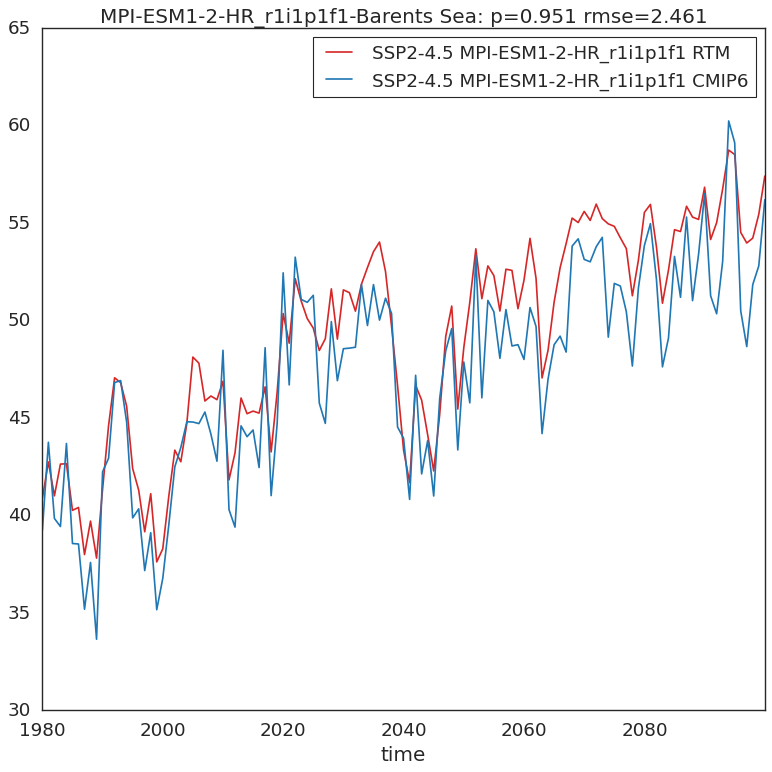

Correlation for Barents Sea MPI-ESM1-2-HR_r1i1p1f1  0.951 (<xarray.DataArray ()> Size: 8B
array(2.58690121e-62)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 2.461
Processing MPI-ESM1-2-HR_r1i1p1f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 

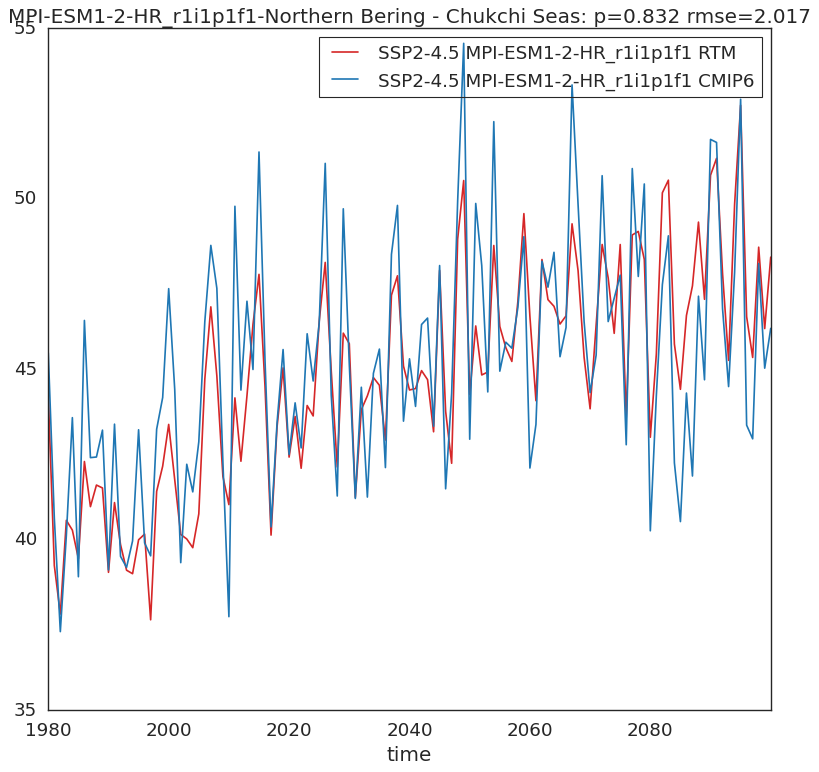

Correlation for Northern Bering - Chukchi Seas MPI-ESM1-2-HR_r1i1p1f1  0.832 (<xarray.DataArray ()> Size: 8B
array(2.78544901e-32)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 2.017
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r'

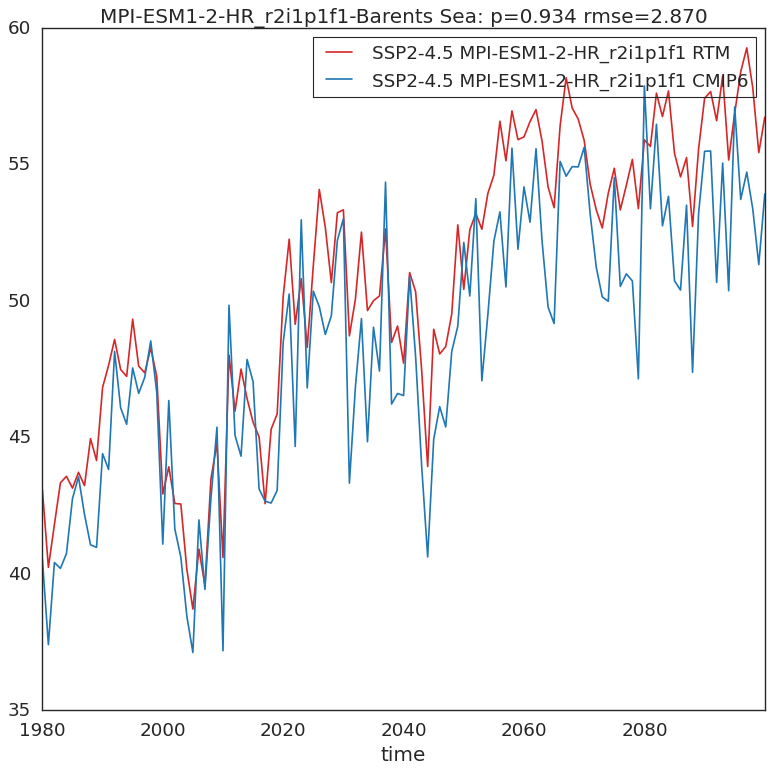

Correlation for Barents Sea MPI-ESM1-2-HR_r2i1p1f1  0.934 (<xarray.DataArray ()> Size: 8B
array(4.58267812e-55)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 2.870
Processing MPI-ESM1-2-HR_r2i1p1f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r2i1p1f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r2i1p1f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 

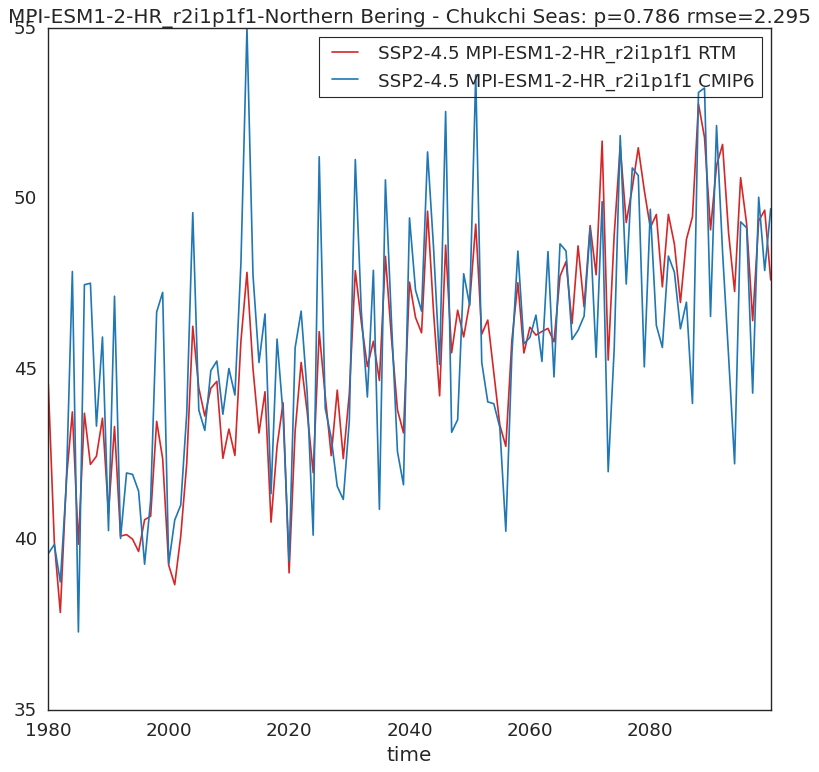

Correlation for Northern Bering - Chukchi Seas MPI-ESM1-2-HR_r2i1p1f1  0.786 (<xarray.DataArray ()> Size: 8B
array(1.24258008e-26)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 2.295
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r'

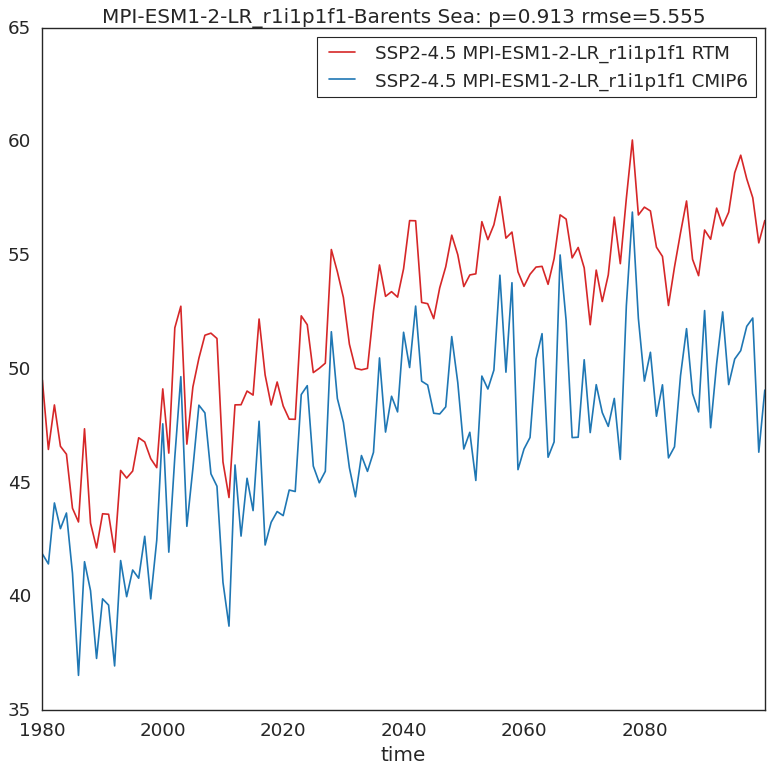

Correlation for Barents Sea MPI-ESM1-2-LR_r1i1p1f1  0.913 (<xarray.DataArray ()> Size: 8B
array(4.82833452e-48)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.555
Processing MPI-ESM1-2-LR_r1i1p1f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 

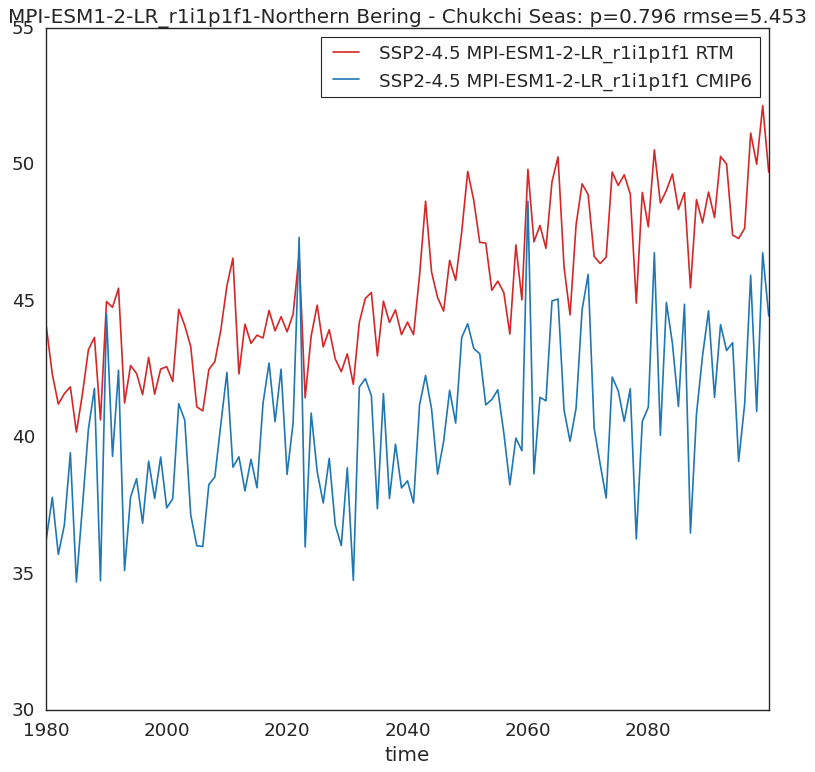

Correlation for Northern Bering - Chukchi Seas MPI-ESM1-2-LR_r1i1p1f1  0.796 (<xarray.DataArray ()> Size: 8B
array(1.17412801e-27)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.453
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r'

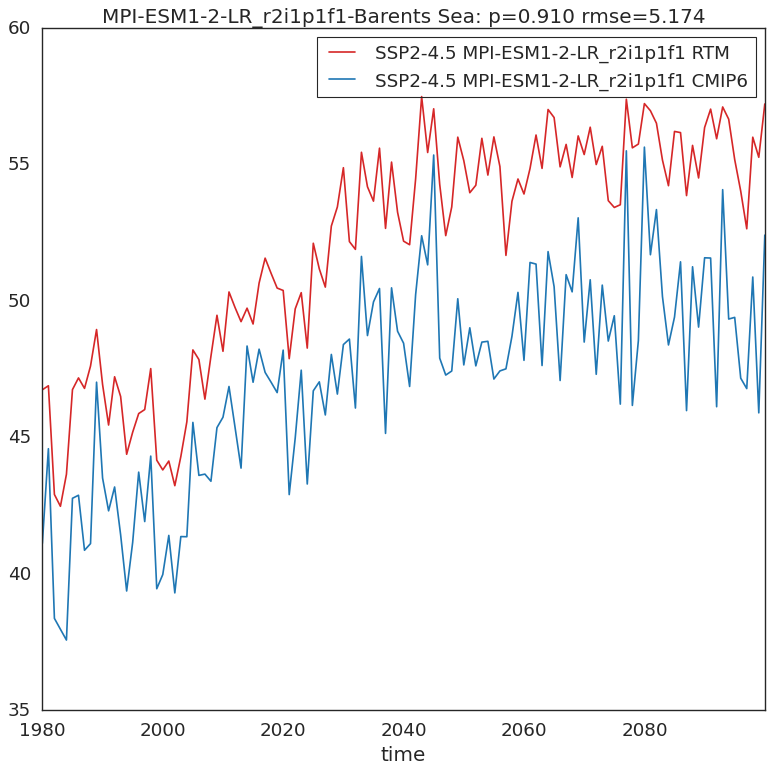

Correlation for Barents Sea MPI-ESM1-2-LR_r2i1p1f1  0.910 (<xarray.DataArray ()> Size: 8B
array(2.10745248e-47)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.174
Processing MPI-ESM1-2-LR_r2i1p1f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 

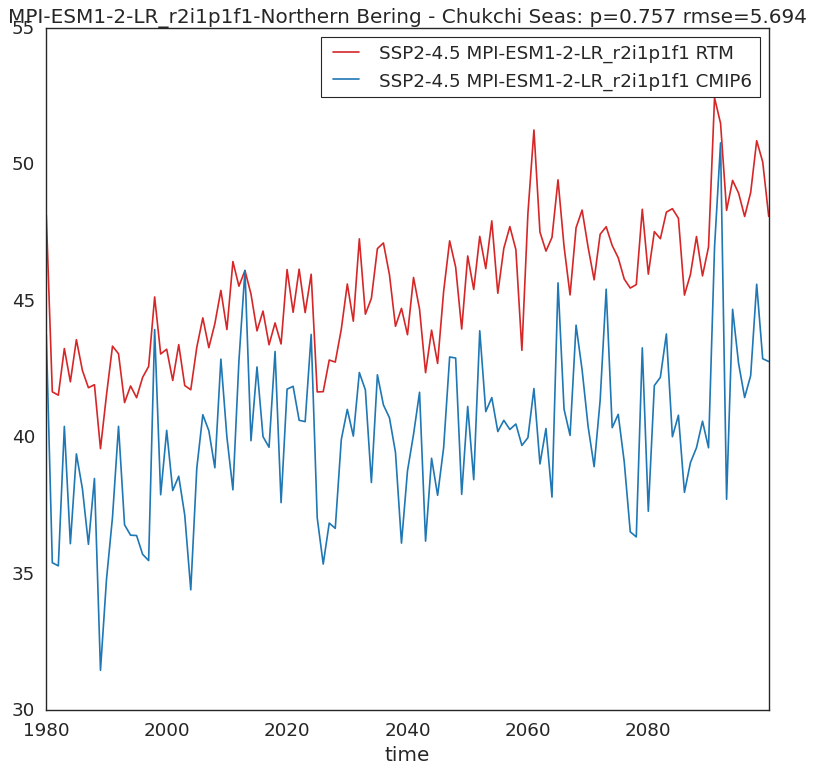

Correlation for Northern Bering - Chukchi Seas MPI-ESM1-2-LR_r2i1p1f1  0.757 (<xarray.DataArray ()> Size: 8B
array(9.79879765e-24)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.694
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r'

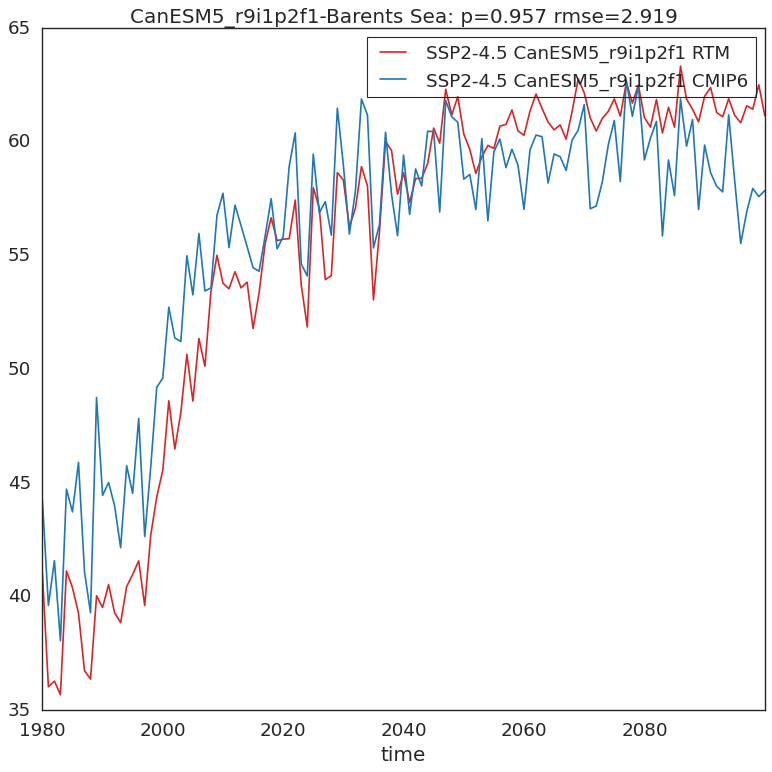

Correlation for Barents Sea CanESM5_r9i1p2f1  0.957 (<xarray.DataArray ()> Size: 8B
array(6.82223925e-66)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 2.919
Processing CanESM5_r9i1p2f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r9i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r9i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r9i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.38812655210494995
pearson p=0.974


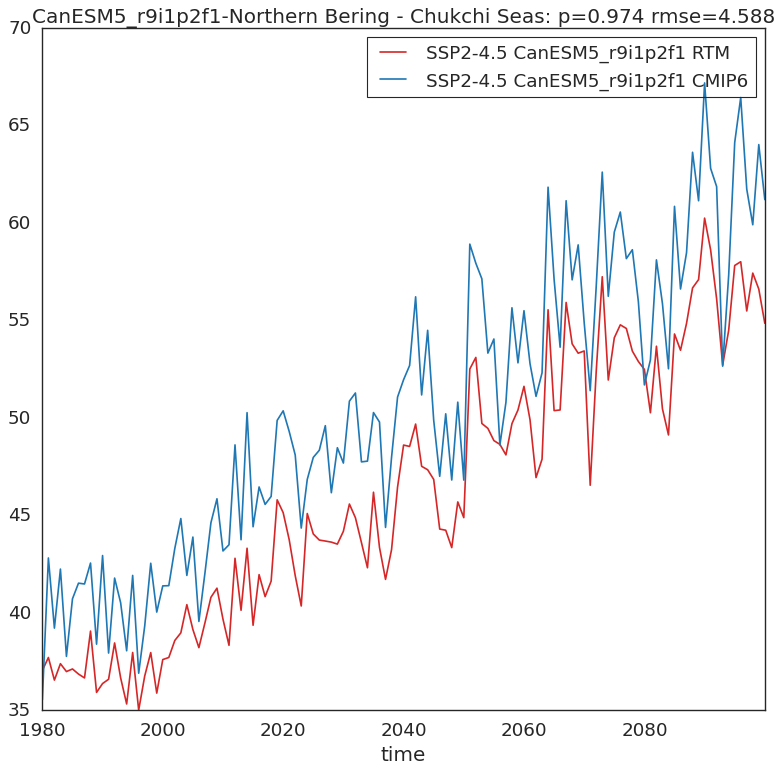

Correlation for Northern Bering - Chukchi Seas CanESM5_r9i1p2f1  0.974 (<xarray.DataArray ()> Size: 8B
array(1.18561526e-78)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 4.588
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.9

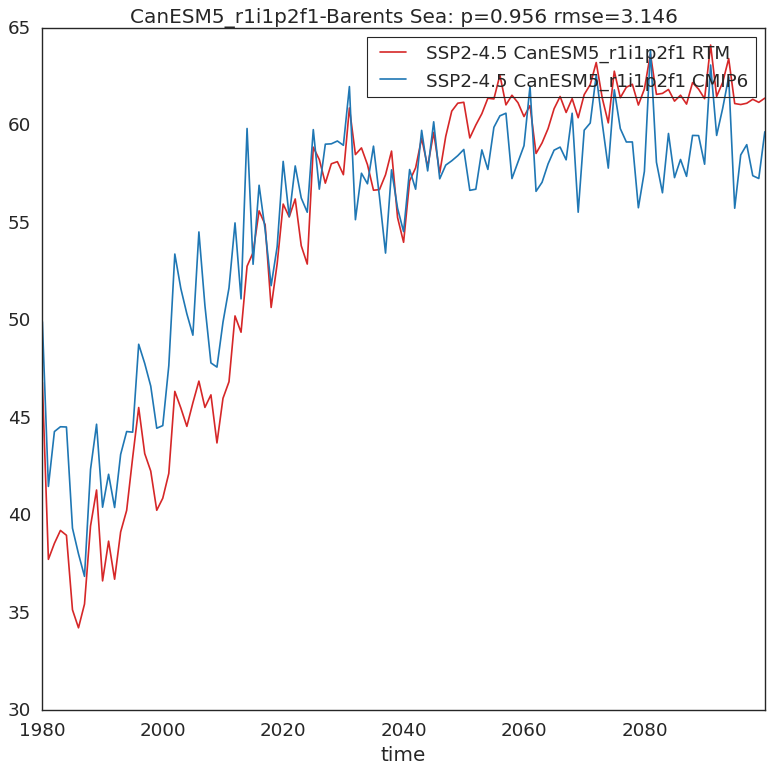

Correlation for Barents Sea CanESM5_r1i1p2f1  0.956 (<xarray.DataArray ()> Size: 8B
array(3.3144413e-65)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 3.146
Processing CanESM5_r1i1p2f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r1i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r1i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.3912551999092102
pearson p=0.971


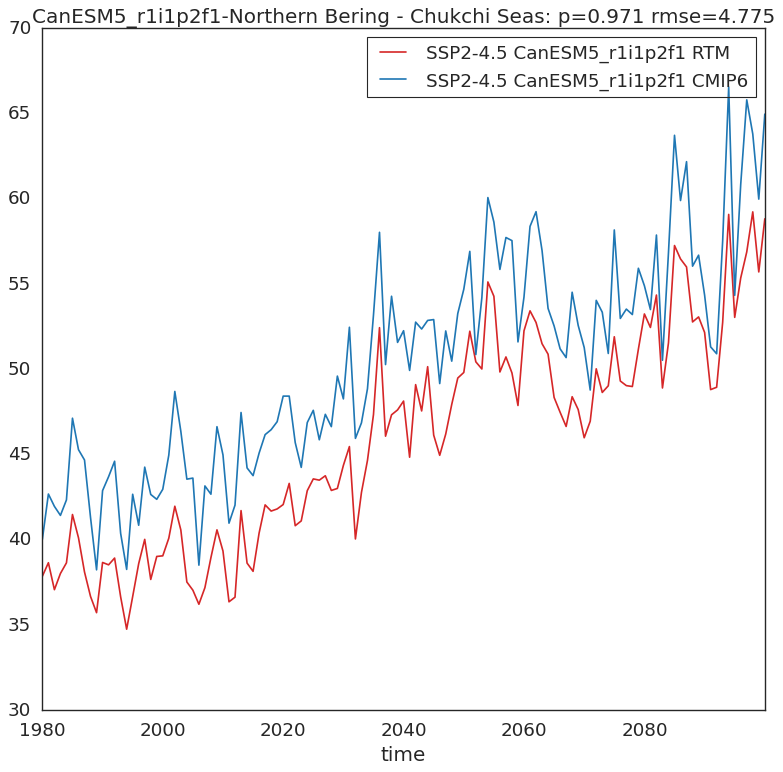

Correlation for Northern Bering - Chukchi Seas CanESM5_r1i1p2f1  0.971 (<xarray.DataArray ()> Size: 8B
array(4.55455655e-76)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 4.775
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.9

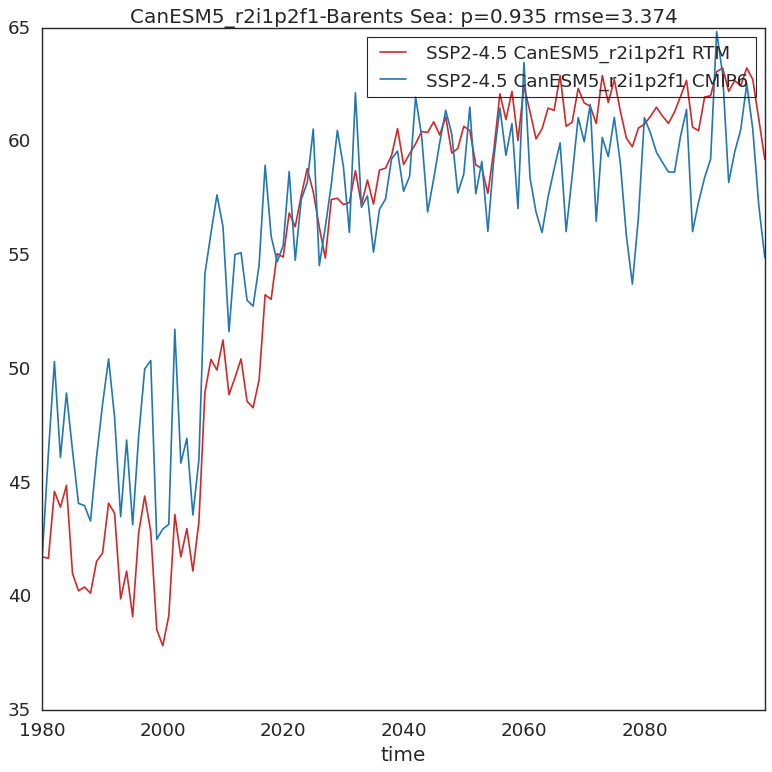

Correlation for Barents Sea CanESM5_r2i1p2f1  0.935 (<xarray.DataArray ()> Size: 8B
array(1.84770112e-55)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 3.374
Processing CanESM5_r2i1p2f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_CanESM5_r2i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r2i1p2f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/CanESM5/CMIP6_CanESM5_r2i1p2f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.3868022859096527
pearson p=0.973


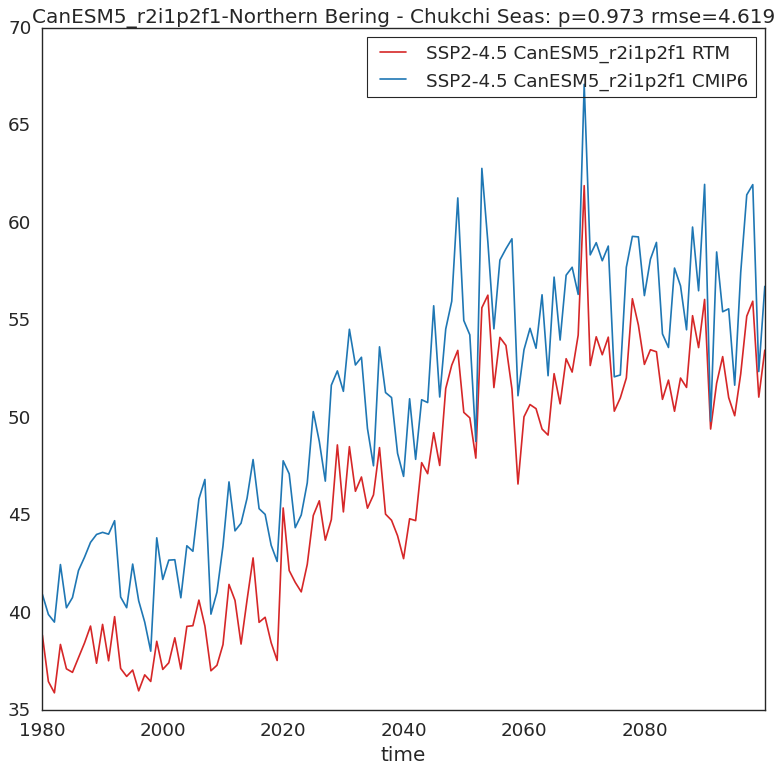

Correlation for Northern Bering - Chukchi Seas CanESM5_r2i1p2f1  0.973 (<xarray.DataArray ()> Size: 8B
array(6.41819724e-78)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 4.619
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.9

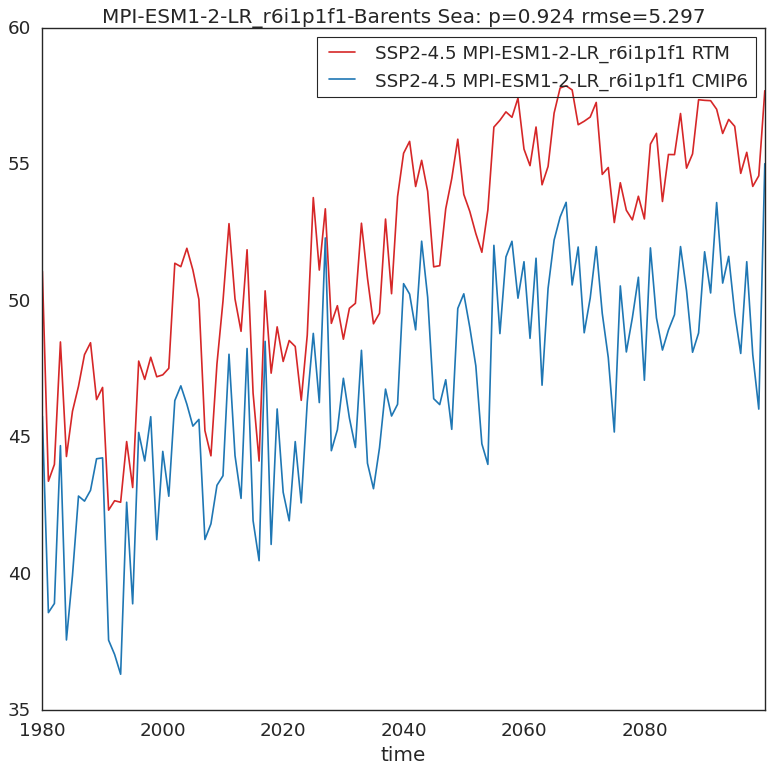

Correlation for Barents Sea MPI-ESM1-2-LR_r6i1p1f1  0.924 (<xarray.DataArray ()> Size: 8B
array(1.29920806e-51)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.297
Processing MPI-ESM1-2-LR_r6i1p1f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r6i1p1f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r6i1p1f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 

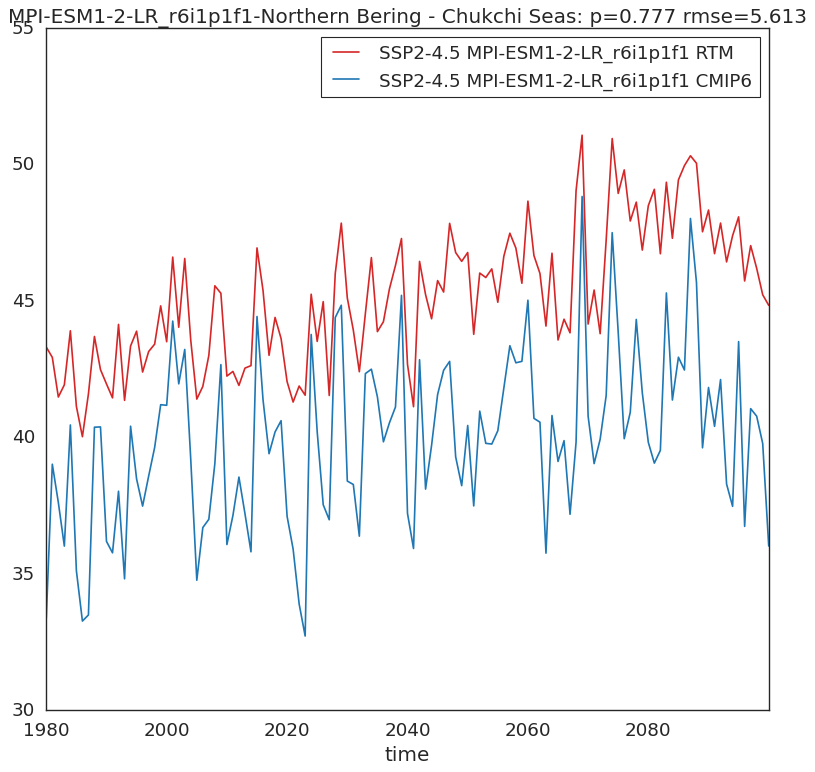

Correlation for Northern Bering - Chukchi Seas MPI-ESM1-2-LR_r6i1p1f1  0.777 (<xarray.DataArray ()> Size: 8B
array(1.02401968e-25)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.613
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r'

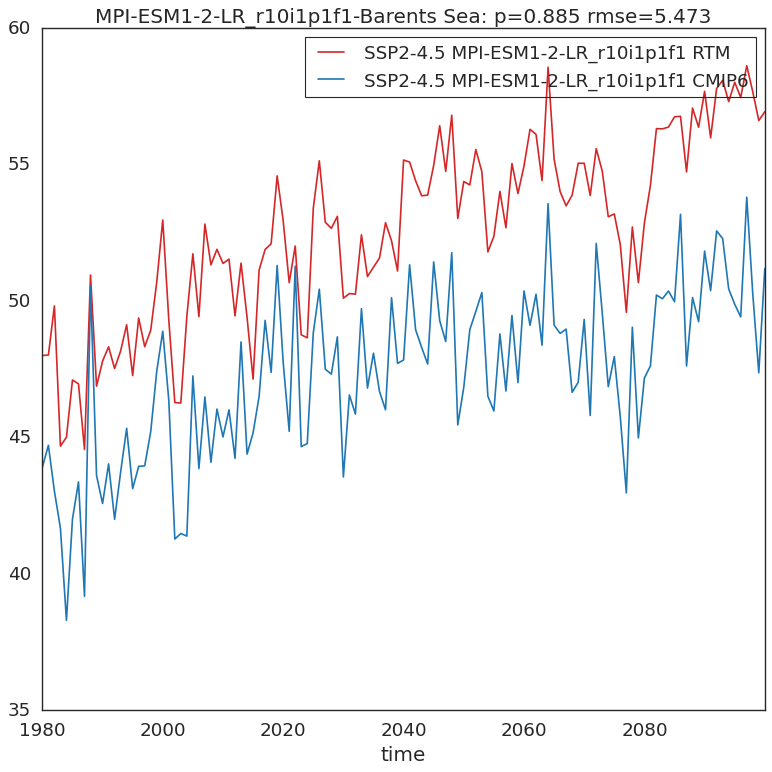

Correlation for Barents Sea MPI-ESM1-2-LR_r10i1p1f1  0.885 (<xarray.DataArray ()> Size: 8B
array(2.14891188e-41)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.473
Processing MPI-ESM1-2-LR_r10i1p1f1 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r10i1p1f1_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r10i1p1f1_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Averag

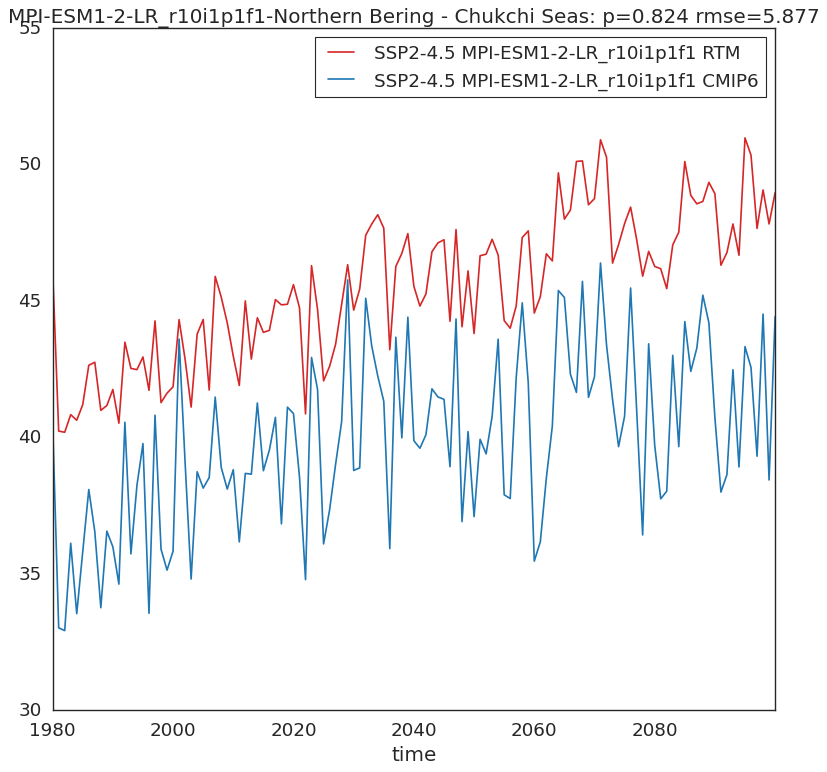

Correlation for Northern Bering - Chukchi Seas MPI-ESM1-2-LR_r10i1p1f1  0.824 (<xarray.DataArray ()> Size: 8B
array(4.29408451e-31)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 5.877
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r

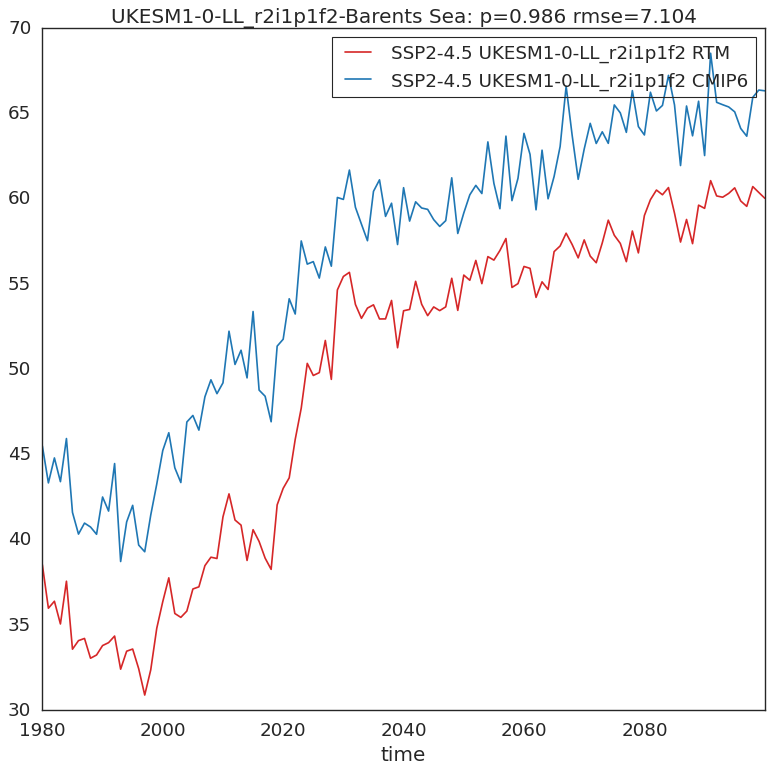

Correlation for Barents Sea UKESM1-0-LL_r2i1p1f2  0.986 (<xarray.DataArray ()> Size: 8B
array(1.17219808e-94)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 7.104
Processing UKESM1-0-LL_r2i1p1f2 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_UKESM1-0-LL_r2i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r2i1p1f2_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r2i1p1f2_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.42114111781120

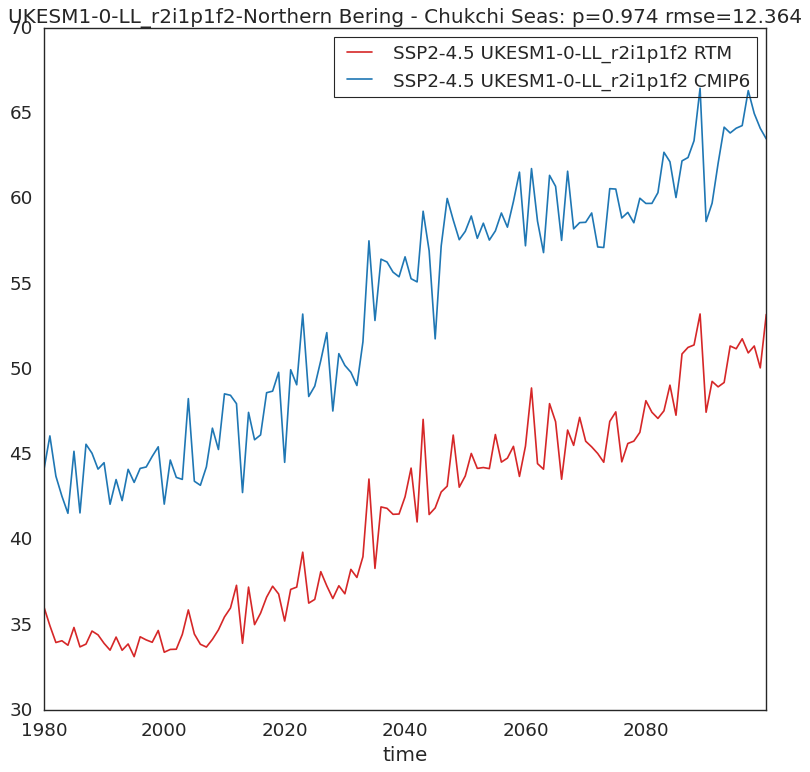

Correlation for Northern Bering - Chukchi Seas UKESM1-0-LL_r2i1p1f2  0.974 (<xarray.DataArray ()> Size: 8B
array(2.24083733e-78)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 12.364
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r':

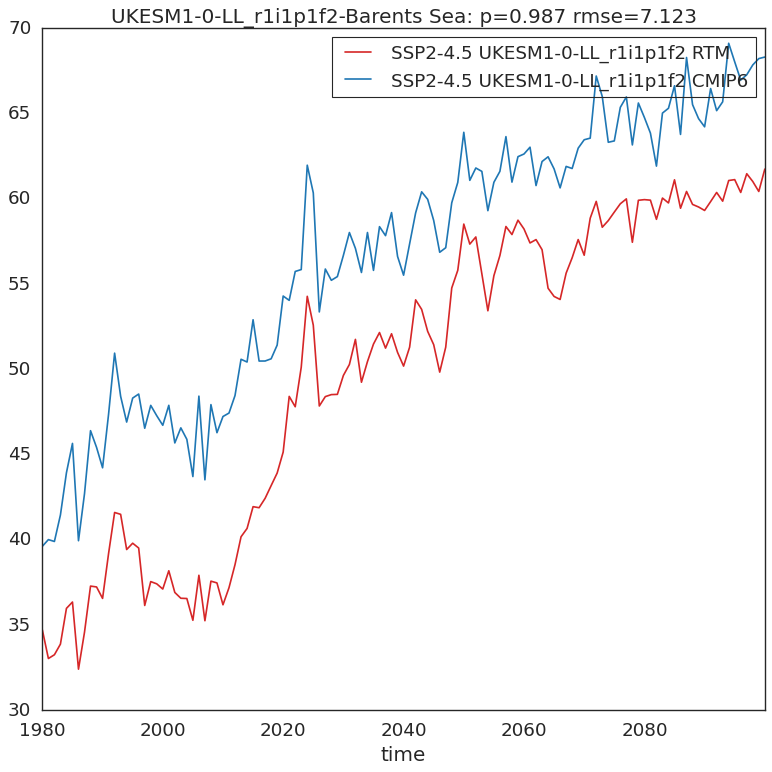

Correlation for Barents Sea UKESM1-0-LL_r1i1p1f2  0.987 (<xarray.DataArray ()> Size: 8B
array(1.15167746e-95)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 7.123
Processing UKESM1-0-LL_r1i1p1f2 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r1i1p1f2_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r1i1p1f2_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.42179852724075

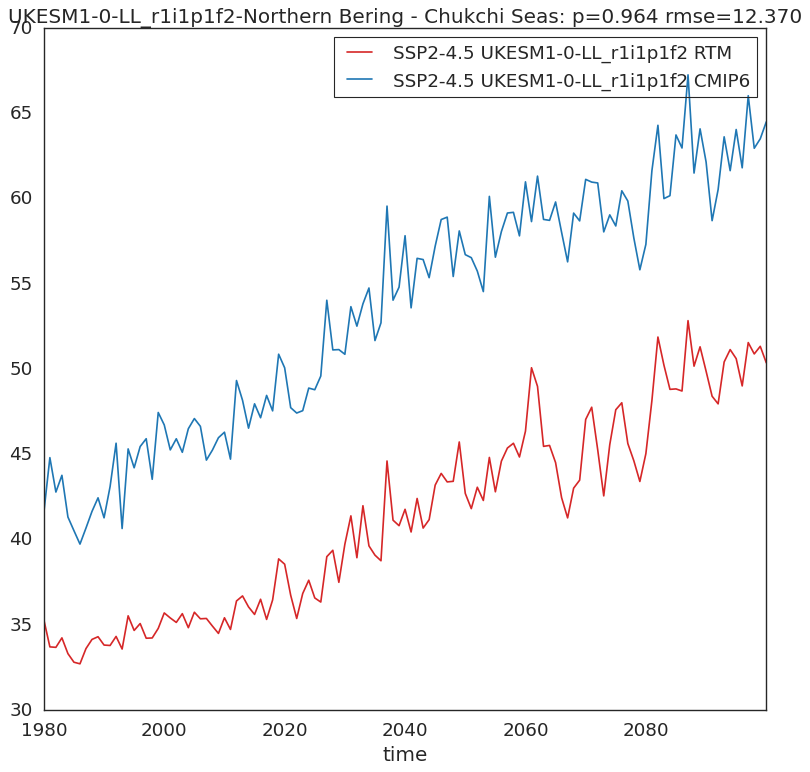

Correlation for Northern Bering - Chukchi Seas UKESM1-0-LL_r1i1p1f2  0.964 (<xarray.DataArray ()> Size: 8B
array(1.5707928e-70)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 12.370
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': 

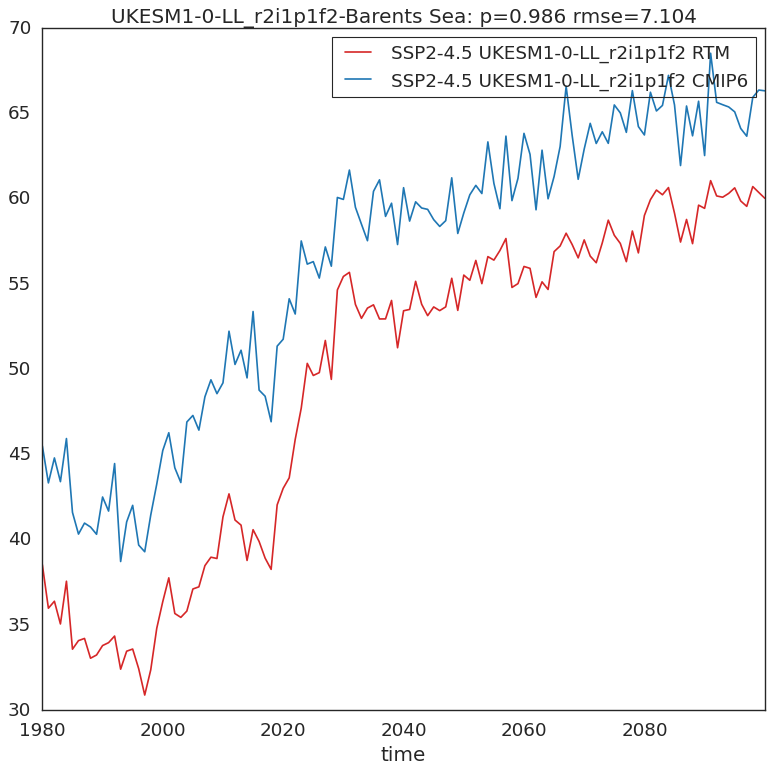

Correlation for Barents Sea UKESM1-0-LL_r2i1p1f2  0.986 (<xarray.DataArray ()> Size: 8B
array(1.17219808e-94)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 7.104
Processing UKESM1-0-LL_r2i1p1f2 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_UKESM1-0-LL_r2i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r2i1p1f2_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r2i1p1f2_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.42114111781120

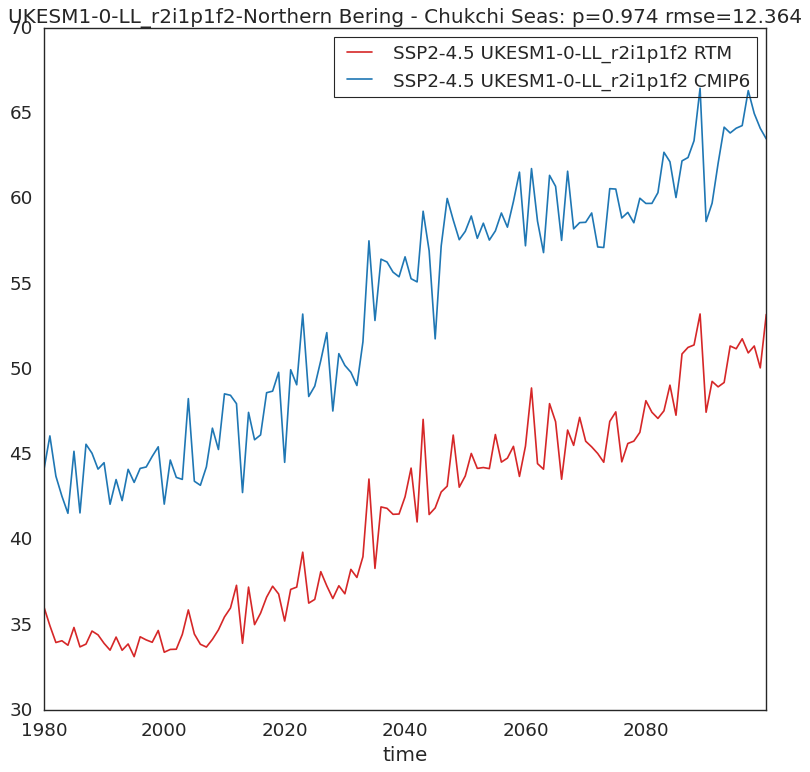

Correlation for Northern Bering - Chukchi Seas UKESM1-0-LL_r2i1p1f2  0.974 (<xarray.DataArray ()> Size: 8B
array(2.24083733e-78)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 12.364
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r':

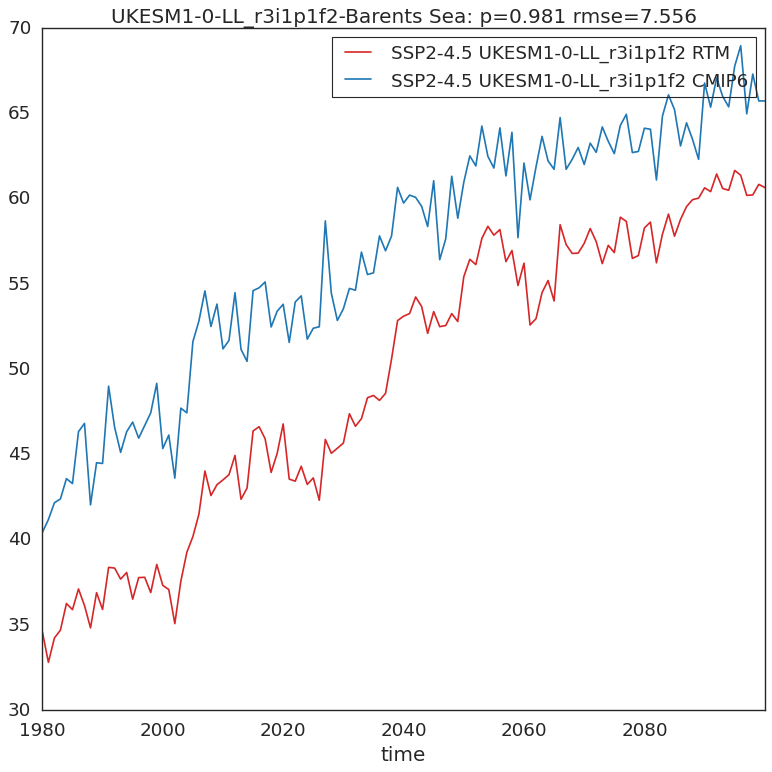

Correlation for Barents Sea UKESM1-0-LL_r3i1p1f2  0.981 (<xarray.DataArray ()> Size: 8B
array(4.24643851e-87)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 7.556
Processing UKESM1-0-LL_r3i1p1f2 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_UKESM1-0-LL_r3i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r3i1p1f2_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r3i1p1f2_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.42026323080062

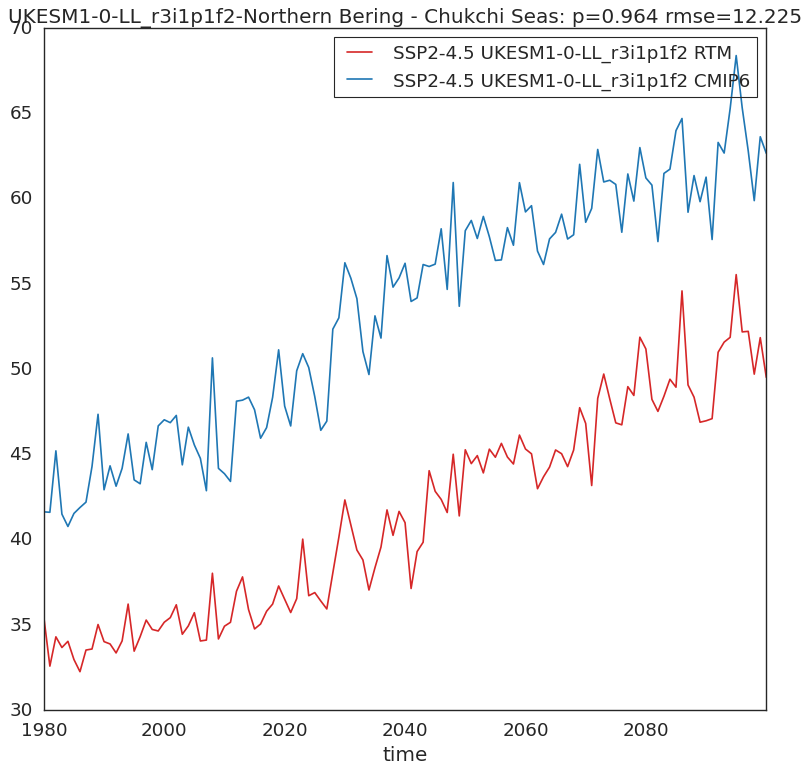

Correlation for Northern Bering - Chukchi Seas UKESM1-0-LL_r3i1p1f2  0.964 (<xarray.DataArray ()> Size: 8B
array(5.68253272e-70)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 12.225
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r':

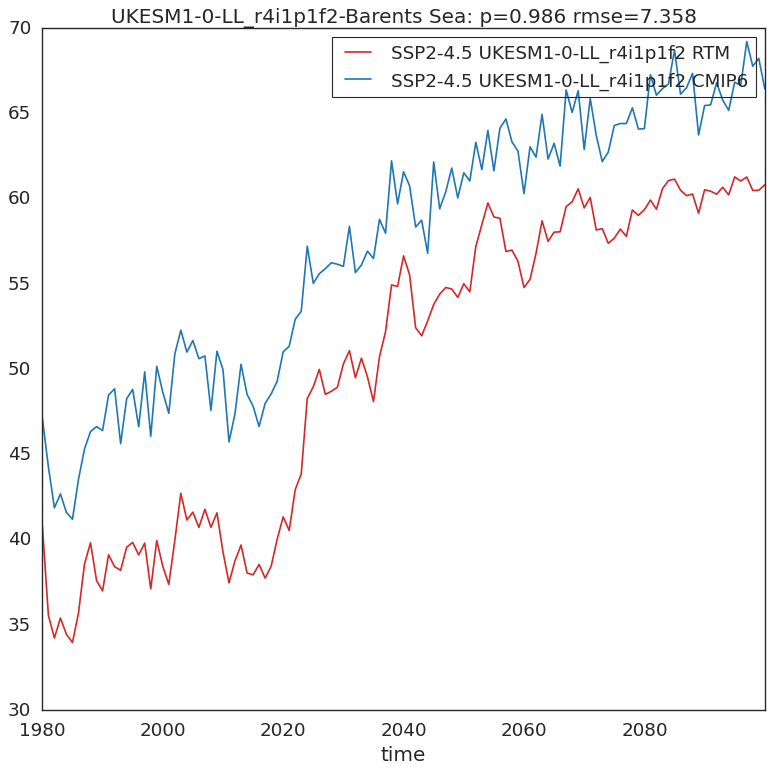

Correlation for Barents Sea UKESM1-0-LL_r4i1p1f2  0.986 (<xarray.DataArray ()> Size: 8B
array(1.16153516e-94)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 7.358
Processing UKESM1-0-LL_r4i1p1f2 ssp245 ghi Northern Bering - Chukchi Seas
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/ghi_UKESM1-0-LL_r4i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r4i1p1f2_ssp245_rsds.nc
[create_land_ocean_mask] Running create_land_ocean_mask
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/UKESM1-0-LL/CMIP6_UKESM1-0-LL_r4i1p1f2_ssp245_rsus.nc
[create_land_ocean_mask] Running create_land_ocean_mask
Average OSA 0.41804513335227

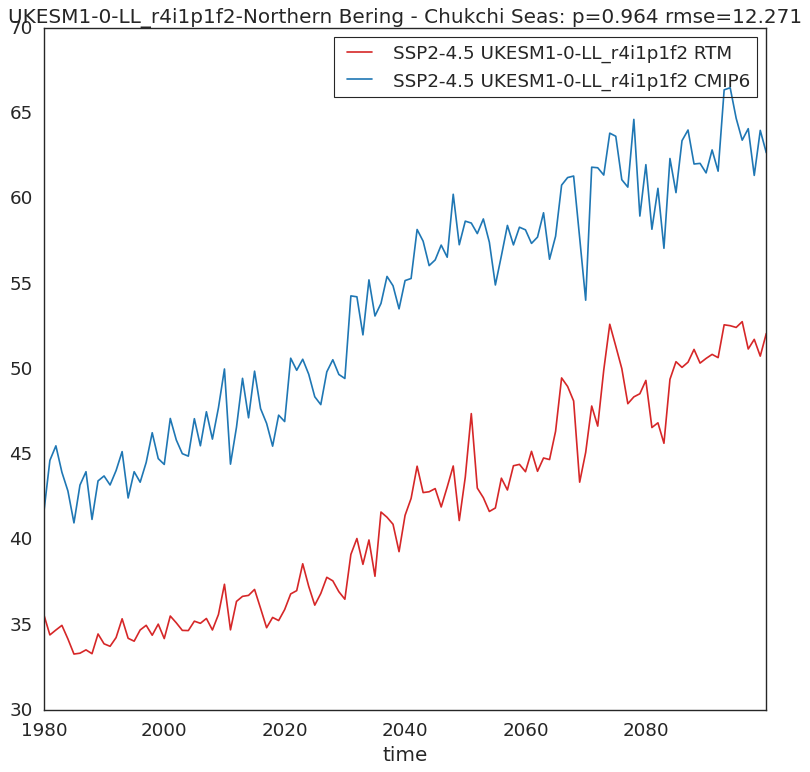

Correlation for Northern Bering - Chukchi Seas UKESM1-0-LL_r4i1p1f2  0.964 (<xarray.DataArray ()> Size: 8B
array(4.3534167e-70)
Coordinates:
    spatial_ref  int64 8B 0) : rmse: 12.271
{'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa_1979_2020': '0.327', 'osa_2081_2100': '0.081'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa_1979_2020': '0.491', 'osa_2081_2100': '0.281'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa_1979_2020': '0.363', 'osa_2081_2100': '0.084'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa_1979_2020': '0.487', 'osa_2081_2100': '0.273'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': 

In [17]:
scenarios = ["ssp245"]
member_range = 12
frequency = "A"
sns.set_style("whitegrid", {'legend.frameon': True})

ds_var_names = ["ghi"]
write_stats_to_file = False
sns.set_theme(style="white", rc={
              "axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

LMES = ["Canadian High Arctic - North Greenland", "Hudson Bay Complex",
        "Central Arctic", "Beaufort Sea", "Northern Bering - Chukchi Seas", "Barents Sea"]
LMES = ["Barents Sea", "Northern Bering - Chukchi Seas"]

# if ocean_only is False then we calculate the full integrated average values
# for the entire LME. If set to True we calculate only the values reaching water column.
ocean_only = True

models = ["CanESM5_r3i1p2f1", 
          "CanESM5_r7i1p2f1",
          "CanESM5_r10i1p2f1",
          "MPI-ESM1-2-HR_r1i1p1f1",
          "MPI-ESM1-2-HR_r2i1p1f1",
          "MPI-ESM1-2-LR_r1i1p1f1",
          "MPI-ESM1-2-LR_r2i1p1f1",
          "CanESM5_r9i1p2f1",
          "CanESM5_r1i1p2f1", 
          "CanESM5_r2i1p2f1",
          "MPI-ESM1-2-LR_r6i1p1f1", 
          "MPI-ESM1-2-LR_r10i1p1f1", 
          "UKESM1-0-LL_r2i1p1f2",
          "UKESM1-0-LL_r1i1p1f2",
          "UKESM1-0-LL_r2i1p1f2",
          "UKESM1-0-LL_r3i1p1f2",
          "UKESM1-0-LL_r4i1p1f2"]

root = f"light/ncfiles_nobias"
bias = 0.0
start_time = "1979-01-01"
end_time = "2099-12-16"

all_stats = {}
all_c3s_ds_BS = {}
all_rtm_ds_BS = {}
all_c3s_ds_CS = {}
all_rtm_ds_CS = {}

for model in models:
    for var_name in ds_var_names:
        for LME in LMES:
            model_name = model.split("_")[0]

            f = plt.figure(figsize=(10, 10))
            gs = f.add_gridspec(1, 1)
            ax = f.add_subplot(gs[0, 0])
            sns.set_palette("tab10")
            loop = 0
            colors_water = ["#8172B3", "#64B5CD"]

            # We loop over all of the scenarios, ensemble_ids, and models to create a
            # list of dataframes that we eventually concatenate together and plot
            for scenario in scenarios:
                if scenario == "ssp585":
                    label = "SSP5-8.5"
                else:
                    label = "SSP2-4.5"
                print(f"Processing {model} {scenario} {var_name} {LME}")
                fname_stats = f"{root}/{scenario}/{var_name}_{model}_1979-01-01-{end_time}_scenario_osa_ssp245.nc"
                fname_stats_osa = f"{root}/{scenario}/osa_{model}_1979-01-01-{end_time}_scenario_osa_ssp245.nc"
                fname_rsds = f"{root}/{scenario}/{model_name}/CMIP6_{model}_{scenario}_rsds.nc"
                fname_rsus = f"{root}/{scenario}/{model_name}/CMIP6_{model}_{scenario}_rsus.nc"

                # get_Greenland_station(fname_stats, var_name)
                ds_rtm = get_area_averaged_ds(
                    fname_stats,
                    LME,
                    var_name,
                    start_time=start_time,
                    end_time=end_time,
                    frequency=frequency,
                    ocean_only=ocean_only,
                )

                ds_rtm_osa = get_area_averaged_ds(
                    fname_stats_osa,
                    LME,
                    "osa",
                    start_time=start_time,
                    end_time=end_time,
                    frequency=frequency,
                    ocean_only=ocean_only,
                )

                ds_rsds = get_area_averaged_ds(
                    fname_rsds,
                    LME,
                    "rsds",
                    start_time=start_time,
                    end_time=end_time,
                    frequency=frequency,
                    ocean_only=ocean_only,
                )

                ds_rsus = get_area_averaged_ds(
                    fname_rsus,
                    LME,
                    "rsus",
                    start_time=start_time,
                    end_time=end_time,
                    frequency=frequency,
                    ocean_only=ocean_only,
                )

                # Calculate the  net radiation. For our model data we use the shortwave radiation and remove the
                # shortwave radiation reflected by the surface. For the model (CMIP6) data we use the net radiation directly
                # but remove the upwelling radiation to get net radiation absorbed.
                ds_rtm_absorbed = (
                    1 - ds_rtm_osa["osa"]) * ds_rtm[var_name] + bias
                ds_net = ds_rsds["rsds"] - ds_rsus["rsus"]
                print(f"Average OSA {np.nanmean(ds_rtm_osa['osa'].values)}")
                
                # Align the datasets along latitude and longitude
                ds1_aligned, ds2_aligned = xr.align(
                    ds_rtm_absorbed, ds_net, join='inner')

                # Create a mask where ds_net is NaN
                mask = np.isnan(ds2_aligned)
                # Apply the mask to ds_rtm_absorbed
                ds_rtm_absorbed = ds1_aligned.where(~mask)
                ds_net = ds2_aligned
                ds_rtm_timeseries = ds_rtm_absorbed.mean(
                    dim=["lat", "lon"], skipna=True)
                ds_c3s_timeseries = ds_net.mean(
                    dim=["lat", "lon"], skipna=True)

                if LME == "Barents Sea":
                    all_rtm_ds_BS[model] = ds_rtm_timeseries
                    all_c3s_ds_BS[model] = ds_c3s_timeseries
                else:
                    all_rtm_ds_CS[model] = ds_rtm_timeseries
                    all_c3s_ds_CS[model] = ds_c3s_timeseries

                ds_rtm_timeseries.plot(
                    ax=ax, color="tab:red", label=f"{label} {model} RTM", add_legend=True)
                ds_c3s_timeseries.plot(
                    ax=ax, color="tab:blue", label=f"{label} {model} CMIP6", add_legend=True)
                
                # Statistics
                r = xs.pearson_r(ds_rtm_timeseries,
                                 ds_c3s_timeseries,
                                 dim='time')
                rmse = xs.rmse(ds_rtm_timeseries,
                               ds_c3s_timeseries,
                               dim='time')
                p = xs.pearson_r_p_value(ds_rtm_timeseries,
                                         ds_c3s_timeseries,
                                         dim="time")
                print(f"pearson p={r:2.3f}")
                plt.legend() 
               # ax.text(100, 40, f'p={r:2.3f} rmse={rmse:3.3f}', size=14, color='black')
                plt.title(f"{model}-{LME}: p={r:2.3f} rmse={rmse:3.3f}")
             
                plt.tight_layout()
                plt.savefig(
                    f"Figures/comparison/{model}_{LME}_timeseries.png", bbox_inches="tight", dpi=200)
                plt.show()


                print(
                    f"Correlation for {LME} {model}  {r:2.3f} ({p}) : rmse: {rmse:3.3f}")
                ind = f"{model}_{scenario}_{LME}"
                all_stats[ind] = {"LME": {LME}, "r": f"{r:2.3f}",
                                  "p": f"{p:2.8f}", 
                                  "rmse": f"{rmse:3.3f}", 
                                  "osa_1979_2020": f"{np.nanmean(ds_rtm_osa['osa'].sel(time=slice('1979-01-01','2020-01-01')).values):3.3f}", 
                                  "osa_2081_2100": f"{np.nanmean(ds_rtm_osa['osa'].sel(time=slice('2081-01-01','2100-01-01')).values):3.3f}"}
                loop += 1
    print(all_stats)

In [18]:
import pandas as pd
dd = {'CanESM5_r3i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '2.786', 'osa': '0.179'}, 'CanESM5_r3i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.972', 'p': '0.00000000', 'rmse': '4.365', 'osa': '0.396'}, 'CanESM5_r7i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.965', 'p': '0.00000000', 'rmse': '3.011', 'osa': '0.196'}, 'CanESM5_r7i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.630', 'osa': '0.387'}, 'CanESM5_r10i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.947', 'p': '0.00000000', 'rmse': '3.142', 'osa': '0.188'}, 'CanESM5_r10i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.981', 'p': '0.00000000', 'rmse': '4.559', 'osa': '0.382'}, 'MPI-ESM1-2-HR_r1i1p1f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.951', 'p': '0.00000000', 'rmse': '2.461', 'osa': '0.270'}, 'MPI-ESM1-2-HR_r1i1p1f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.832', 'p': '0.00000000', 'rmse': '2.017', 'osa': '0.389'}, 'MPI-ESM1-2-HR_r2i1p1f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.934', 'p': '0.00000000', 'rmse': '2.870', 'osa': '0.248'}, 'MPI-ESM1-2-HR_r2i1p1f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.786', 'p': '0.00000000', 'rmse': '2.295', 'osa': '0.380'}, 'MPI-ESM1-2-LR_r1i1p1f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.913', 'p': '0.00000000', 'rmse': '5.555', 'osa': '0.219'}, 'MPI-ESM1-2-LR_r1i1p1f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.796', 'p': '0.00000000', 'rmse': '5.453', 'osa': '0.379'}, 'MPI-ESM1-2-LR_r2i1p1f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.910', 'p': '0.00000000', 'rmse': '5.174', 'osa': '0.222'}, 'MPI-ESM1-2-LR_r2i1p1f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.757', 'p': '0.00000000', 'rmse': '5.694', 'osa': '0.380'}, 'CanESM5_r9i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.957', 'p': '0.00000000', 'rmse': '2.919', 'osa': '0.185'}, 'CanESM5_r9i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.974', 'p': '0.00000000', 'rmse': '4.588', 'osa': '0.388'}, 'CanESM5_r1i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.956', 'p': '0.00000000', 'rmse': '3.146', 'osa': '0.191'}, 'CanESM5_r1i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.971', 'p': '0.00000000', 'rmse': '4.775', 'osa': '0.391'}, 'CanESM5_r2i1p2f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.935', 'p': '0.00000000', 'rmse': '3.374', 'osa': '0.186'}, 'CanESM5_r2i1p2f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.973', 'p': '0.00000000', 'rmse': '4.619', 'osa': '0.387'}, 'MPI-ESM1-2-LR_r6i1p1f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.924', 'p': '0.00000000', 'rmse': '5.297', 'osa': '0.224'}, 'MPI-ESM1-2-LR_r6i1p1f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.777', 'p': '0.00000000', 'rmse': '5.613', 'osa': '0.383'}, 'MPI-ESM1-2-LR_r10i1p1f1_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.885', 'p': '0.00000000', 'rmse': '5.473', 'osa': '0.213'}, 'MPI-ESM1-2-LR_r10i1p1f1_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.824', 'p': '0.00000000', 'rmse': '5.877', 'osa': '0.379'}, 'UKESM1-0-LL_r2i1p1f2_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.986', 'p': '0.00000000', 'rmse': '7.104', 'osa': '0.249'}, 'UKESM1-0-LL_r2i1p1f2_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.974', 'p': '0.00000000', 'rmse': '12.364', 'osa': '0.421'}, 'UKESM1-0-LL_r1i1p1f2_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.987', 'p': '0.00000000', 'rmse': '7.123', 'osa': '0.242'}, 'UKESM1-0-LL_r1i1p1f2_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.964', 'p': '0.00000000', 'rmse': '12.370', 'osa': '0.422'}, 'UKESM1-0-LL_r3i1p1f2_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.981', 'p': '0.00000000', 'rmse': '7.556', 'osa': '0.248'}, 'UKESM1-0-LL_r3i1p1f2_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.964', 'p': '0.00000000', 'rmse': '12.225', 'osa': '0.420'}, 'UKESM1-0-LL_r4i1p1f2_ssp245_Barents Sea': {'LME': {'Barents Sea'}, 'r': '0.986', 'p': '0.00000000', 'rmse': '7.358', 'osa': '0.237'}, 'UKESM1-0-LL_r4i1p1f2_ssp245_Northern Bering - Chukchi Seas': {'LME': {'Northern Bering - Chukchi Seas'}, 'r': '0.964', 'p': '0.00000000', 'rmse': '12.271', 'osa': '0.418'}}
df = pd.DataFrame.from_dict(dd, orient='index').reset_index()

print(df)

                                                index  \
0                 CanESM5_r3i1p2f1_ssp245_Barents Sea   
1   CanESM5_r3i1p2f1_ssp245_Northern Bering - Chuk...   
2                 CanESM5_r7i1p2f1_ssp245_Barents Sea   
3   CanESM5_r7i1p2f1_ssp245_Northern Bering - Chuk...   
4                CanESM5_r10i1p2f1_ssp245_Barents Sea   
5   CanESM5_r10i1p2f1_ssp245_Northern Bering - Chu...   
6           MPI-ESM1-2-HR_r1i1p1f1_ssp245_Barents Sea   
7   MPI-ESM1-2-HR_r1i1p1f1_ssp245_Northern Bering ...   
8           MPI-ESM1-2-HR_r2i1p1f1_ssp245_Barents Sea   
9   MPI-ESM1-2-HR_r2i1p1f1_ssp245_Northern Bering ...   
10          MPI-ESM1-2-LR_r1i1p1f1_ssp245_Barents Sea   
11  MPI-ESM1-2-LR_r1i1p1f1_ssp245_Northern Bering ...   
12          MPI-ESM1-2-LR_r2i1p1f1_ssp245_Barents Sea   
13  MPI-ESM1-2-LR_r2i1p1f1_ssp245_Northern Bering ...   
14                CanESM5_r9i1p2f1_ssp245_Barents Sea   
15  CanESM5_r9i1p2f1_ssp245_Northern Bering - Chuk...   
16                CanESM5_r1i1p

In [19]:
def plot_distributions(df):
    # Set up the plot style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    print(df)

    # Plot the distributions using seaborn
    sns.histplot(data=df, x="mean", hue="dataset", kde=True,
                 stat="density", common_norm=False)

    # Customize the plot
    plt.title("Distribution of shortwave radiation")
    plt.xlabel("SW (W/m2)")
    plt.ylabel("Density")

    # Add a legend
    plt.legend(title="Dataset")

    # Show the plot
    plt.show()

In [20]:
import json

# Initialize variables to store the sum of statistics
sum_r = 0
sum_rmse = 0
count = 0
LMES = ["Barents Sea", "Northern Bering - Chukchi Seas"]

for LME in LMES:
    # Loop through the dictionary and calculate the sum of statistics for "Barents Sea"
    for key, value in all_stats.items():
        if LME in key:
            sum_r += float(value['r'])
            sum_rmse += float(value['rmse'])
           
            count += 1
    # Calculate the average statistics
    if count > 0:
        avg_r = sum_r / count
        avg_rmse = sum_rmse / count
        print(f"{LME} Average r: {avg_r}")
        print(f"{LME} Average rmse: {avg_rmse} W/m2")
    else:
        print(f"No entries found for {LME}")
        
    sum_r = 0
    sum_rmse = 0
    count = 0
    
    

Barents Sea Average r: 0.948875
Barents Sea Average rmse: 4.6468125 W/m2
Northern Bering - Chukchi Seas Average r: 0.9051250000000001
Northern Bering - Chukchi Seas Average rmse: 6.4821875 W/m2


     model       time       mean       std dataset
0        0 1979-12-31        NaN       NaN   CMIP6
1        0 1980-12-31  40.474663  3.322562   CMIP6
2        0 1981-12-31  40.001740  3.429928   CMIP6
3        0 1982-12-31  40.194504  3.032186   CMIP6
4        0 1983-12-31  40.484291  2.916221   CMIP6
..     ...        ...        ...       ...     ...
237      0 2095-12-31  52.156384  3.685389     RTM
238      0 2096-12-31  51.864235  3.994576     RTM
239      0 2097-12-31  52.056068  3.832142     RTM
240      0 2098-12-31  52.028069  3.775733     RTM
241      0 2099-12-31  51.930717  4.050968     RTM

[242 rows x 5 columns]
     model       time       mean       std dataset
0        0 1979-12-31        NaN       NaN   CMIP6
1        0 1980-12-31  40.474663  3.322562   CMIP6
2        0 1981-12-31  40.001740  3.429928   CMIP6
3        0 1982-12-31  40.194504  3.032186   CMIP6
4        0 1983-12-31  40.484291  2.916221   CMIP6
..     ...        ...        ...       ...     ...
237    

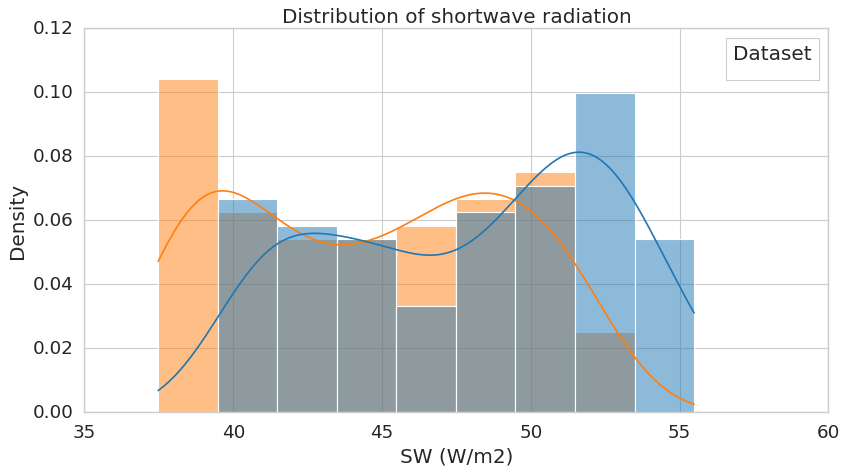

   model       time       mean       std dataset
0      0 1979-12-31        NaN       NaN   CMIP6
1      0 1980-12-31  40.474663  3.322562   CMIP6
2      0 1981-12-31  40.001740  3.429928   CMIP6
3      0 1982-12-31  40.194504  3.032186   CMIP6
4      0 1983-12-31  40.484291  2.916221   CMIP6


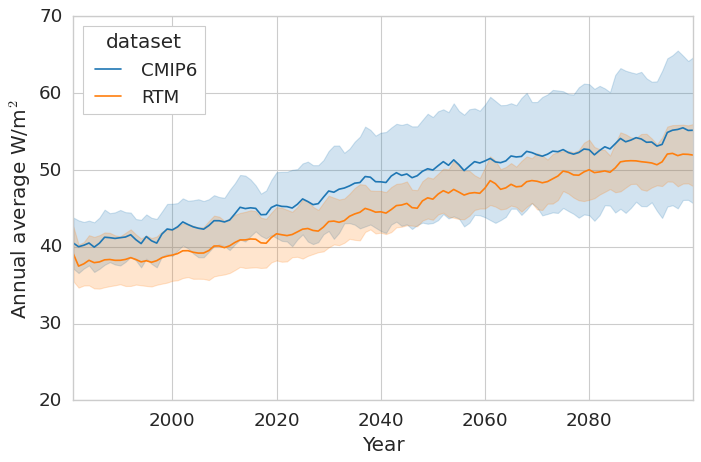

     model       time       mean       std dataset
0        0 1979-12-31        NaN       NaN   CMIP6
1        0 1980-12-31  43.028610  2.885104   CMIP6
2        0 1981-12-31  42.477516  2.896995   CMIP6
3        0 1982-12-31  42.378105  2.865722   CMIP6
4        0 1983-12-31  42.892342  3.107658   CMIP6
..     ...        ...        ...       ...     ...
237      0 2095-12-31  59.682854  2.520743     RTM
238      0 2096-12-31  59.465542  2.865852     RTM
239      0 2097-12-31  59.502495  2.884565     RTM
240      0 2098-12-31  59.278854  2.819272     RTM
241      0 2099-12-31  59.321613  2.465790     RTM

[242 rows x 5 columns]
     model       time       mean       std dataset
0        0 1979-12-31        NaN       NaN   CMIP6
1        0 1980-12-31  43.028610  2.885104   CMIP6
2        0 1981-12-31  42.477516  2.896995   CMIP6
3        0 1982-12-31  42.378105  2.865722   CMIP6
4        0 1983-12-31  42.892342  3.107658   CMIP6
..     ...        ...        ...       ...     ...
237    

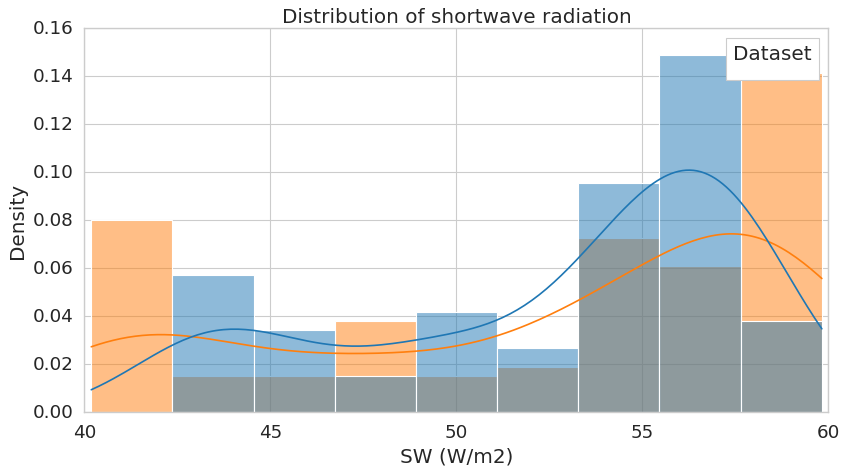

   model       time       mean       std dataset
0      0 1979-12-31        NaN       NaN   CMIP6
1      0 1980-12-31  43.028610  2.885104   CMIP6
2      0 1981-12-31  42.477516  2.896995   CMIP6
3      0 1982-12-31  42.378105  2.865722   CMIP6
4      0 1983-12-31  42.892342  3.107658   CMIP6


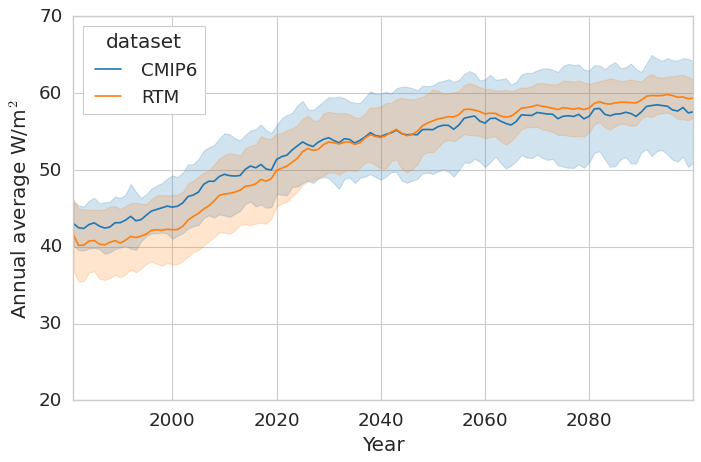

In [21]:
# Function to compute rolling mean and standard deviation
def compute_rolling_stats(data_dict, window=2):
    rolling_means = []
    rolling_stds = []

    all_da = []
    for key, da in data_dict.items():
        all_da.append(da)

    # concatenate along time dimension
    data_stacked = xr.concat(all_da, dim='ensemble')
    # compute mean
    mean = data_stacked.mean(dim="ensemble").resample(time="A").mean()
    std = data_stacked.std(dim="ensemble").resample(time="A").mean()

    rolling_mean = mean.rolling(time=window, center=True).mean()
    rolling_std = std.rolling(time=window, center=True).mean()
    rolling_means.append(rolling_mean)
    rolling_stds.append(rolling_std)

    return xr.concat(rolling_means, dim='model'), xr.concat(rolling_stds, dim='model')


# Convert to DataFrame for Seaborn
def to_dataframe(mean, std, label):
    df = mean.to_dataframe(name='mean').reset_index()
    df_std = std.to_dataframe(name='std').reset_index()
    df = pd.concat([df, df_std["std"]], axis=1)
    df['dataset'] = label
    df.drop(labels='spatial_ref', axis=1, inplace=True)
    return df


for LME, all_ds_rtm, all_cs3_ds in zip(LMES, [all_rtm_ds_CS, all_rtm_ds_BS], [all_c3s_ds_CS, all_c3s_ds_BS]):
    # Compute rolling means and standard deviations

    rtm_mean, rtm_std = compute_rolling_stats(all_ds_rtm)
    c3s_mean, c3s_std = compute_rolling_stats(all_cs3_ds)

    rtm_df = to_dataframe(rtm_mean, rtm_std, 'RTM')
    c3s_df = to_dataframe(c3s_mean, c3s_std, 'CMIP6')

    # Combine dataframes
    combined_df = pd.concat([c3s_df, rtm_df])
    combined_df = combined_df.reset_index(drop=True)
    # combined_df = combined_df.set_index("time")
    print(combined_df)

    plot_distributions(combined_df)

    print(combined_df.head())

    # Plot using Seaborn
    sns.set_style("whitegrid")
    sns.color_palette("tab10")
    plt.figure(figsize=(10, 6))

 #   df_rtm = combined_df[combined_df['dataset']=="RTM"]
 #   df_rtm["mean"]=df_rtm["mean"] + 9
 #   combined_df[combined_df['dataset']=="RTM"]=df_rtm
    plt.fill_between(c3s_df['time'], c3s_df['mean'] - c3s_df['std'],
                     c3s_df['mean'] + c3s_df['std'], alpha=0.2, color=plt.cm.tab10.colors[0])
    plt.fill_between(rtm_df['time'], rtm_df['mean'] - rtm_df['std'],
                     rtm_df['mean'] + rtm_df['std'], alpha=0.2, color=plt.cm.tab10.colors[1])
    ax = sns.lineplot(data=combined_df, x='time', y='mean', hue='dataset', ci=None)
    sns.move_legend(ax, "upper left")
   
    plt.xlabel('Year')
    plt.ylabel('Annual average W/m$^{2}$')
    plt.ylim(20, 70)
    plt.savefig(f"Figures/RTM_CMIP6_timeseries_{LME}.png")
    plt.show()